In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass


In [14]:
PATH = "F:\\MRI_class\\data\\Alzheimer_Dataset2\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(PATH, seed=1, shuffle=True, image_size=IMAGE_SIZE)

Found 8188 files belonging to 4 classes.


In [15]:
PATH = "F:\\MRI_class\\data\\Alzheimer_Dataset2\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(PATH, seed=1, shuffle=True, image_size=IMAGE_SIZE)

Found 2054 files belonging to 4 classes.


In [16]:
for img,lable in train_ds.take(1):
    plt.imshow(img[0].numpy().astype("uint8"))


InvalidArgumentError: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext]

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

InvalidArgumentError: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext]

<Figure size 720x720 with 0 Axes>

In [13]:

target_train = to_categorical(target_train)
target_val = to_categorical(target_val)

In [14]:

X_train, y_train = shuffle(train_images, target_train, random_state=10)
X_val, y_val = shuffle(val_images, target_val, random_state=10)


In [15]:
y_val

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [16]:

val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))

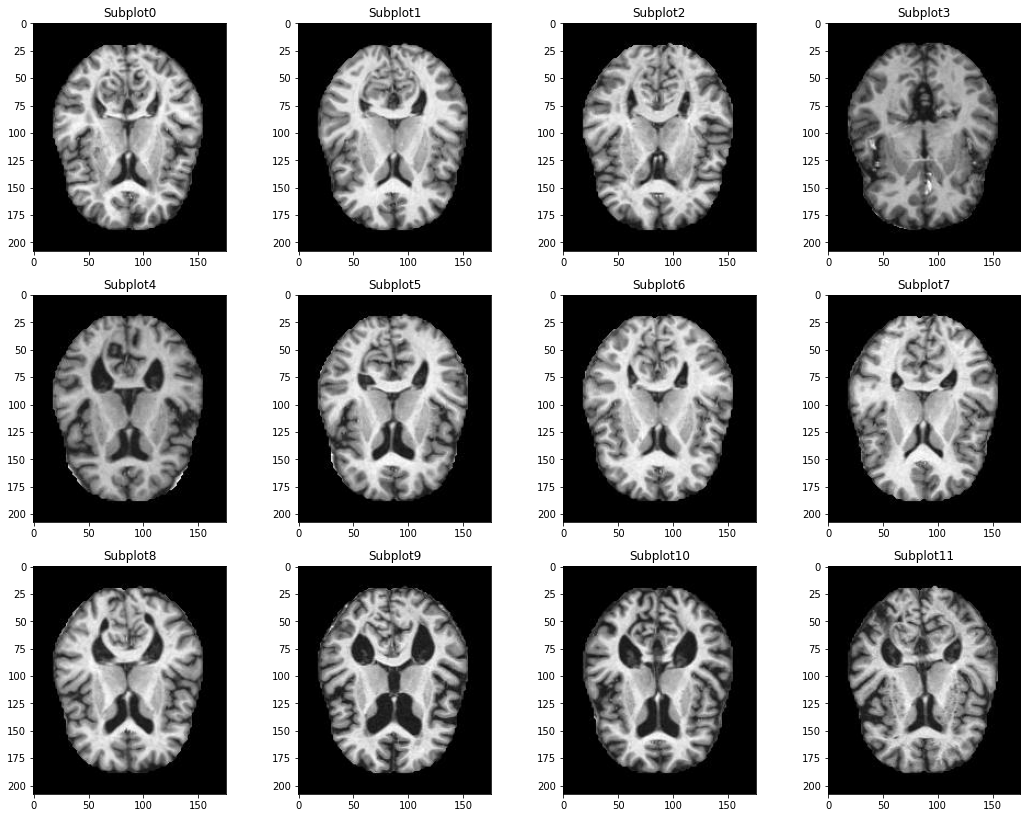

In [17]:
#visualization of couple brains
cols= 4
rows = 4
axes = []
width = 1000
height = 1000

fig = plt.figure(figsize=(15, 15))

for a in range(0,12):
    b = val_images[a].astype('uint8')
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b,cmap="gray")
fig.tight_layout()
plt.show()

In [19]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Conv2D(50, (3, 3), activation='relu', input_shape=(208, 176, 1)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [20]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))


In [21]:
#model.summary()

In [22]:
EPOCHS = 40
BATCH_SIZE = 20
STEPS_PER_EPOCH = len(train_images)*0.6 // BATCH_SIZE

val_set = val_set.batch(BATCH_SIZE)


In [23]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [24]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              #loss="binary_crossentropy",
              metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])

with tf.device("/gpu:0"):
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        shuffle=True,
                        validation_data=val_set)
                    

Epoch 1/40
122/122 [==============================] - 6s 31ms/step - loss: 1.3868 - accuracy: 0.4410 - precision: 0.4628 - recall: 0.2012 - auc: 0.7158 - val_loss: 1.0585 - val_accuracy: 0.5404 - val_precision: 1.0000 - val_recall: 0.0175 - val_auc: 0.8124
Epoch 2/40
122/122 [==============================] - 4s 30ms/step - loss: 1.0511 - accuracy: 0.5119 - precision: 0.6340 - recall: 0.2605 - auc: 0.7938 - val_loss: 0.9586 - val_accuracy: 0.5073 - val_precision: 0.6650 - val_recall: 0.3982 - val_auc: 0.8378
Epoch 3/40
122/122 [==============================] - 3s 28ms/step - loss: 1.0184 - accuracy: 0.5131 - precision: 0.6437 - recall: 0.3020 - auc: 0.8050 - val_loss: 0.9236 - val_accuracy: 0.5910 - val_precision: 0.8343 - val_recall: 0.2746 - val_auc: 0.8578
Epoch 4/40
122/122 [==============================] - 3s 27ms/step - loss: 0.9617 - accuracy: 0.5542 - precision: 0.6746 - recall: 0.3484 - auc: 0.8277 - val_loss: 0.8900 - val_accuracy: 0.6378 - val_precision: 0.8500 - val_recal

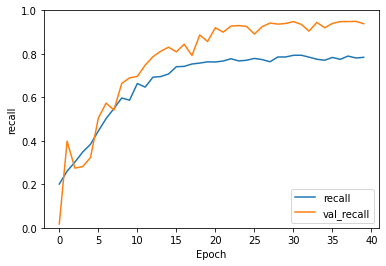

33/33 - 1s - loss: 0.1715 - accuracy: 0.9503 - precision: 0.9708 - recall: 0.9387 - auc: 0.9935 - 784ms/epoch - 24ms/step


In [25]:
#print val vs accuracy

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


test_loss, test_acc, test_prec, test_rec, test_auc  = model.evaluate(X_val, y_val, verbose=2)

In [27]:
y_pred = model.predict(X_val)


NameError: name 'model' is not defined

MACRO ROC AUC SCORE: 0.8471416405839487


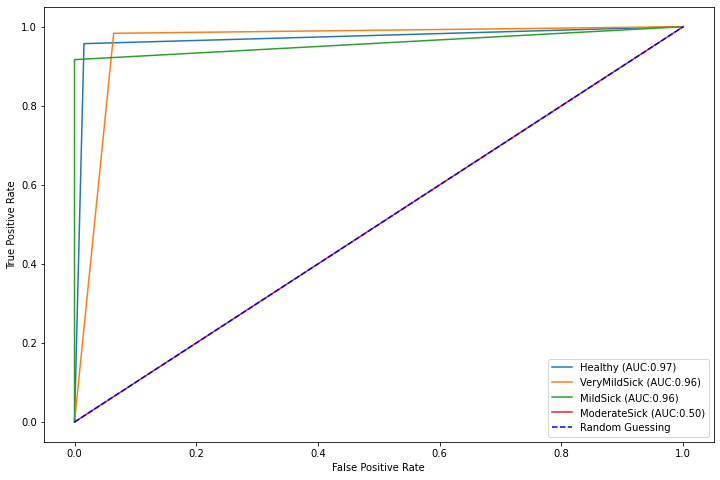

In [27]:
roc_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

In [28]:
def roc_multiclass(y_pred,y_val,target_list,variant):
    
    '''
    Args:   y_pred - raw output of model prediction (should be real proba values)
            y_val - validation set as used in cnn model (should be sparse dummy columns)
            target_list - list containing targets as strings
            variant - "macro" or "micro": sets the averaging method 
    retuns: Plots the individual Roc-auc curves of every class.
            Also prints the "macro" or "micro" average Roc-auc-score
    '''


    # flatten CNN output in such way that we change the sparse columns (each only containing 0 and 1)
    # to one column labeling classes as continues numbers. e.g. 1,2,3,4 (etc)
    y_pred = np.argmax(y_pred,axis=-1)
    y_val = np.argmax(y_val, axis=-1)

    # set plot figure size
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

    # core function: here the roc score is calculated. The estimator results are calculated for all
    # thresholds. Macro sets the evaluation to "one vs all".
    # Multiclass_roc_auc_score is acutually the roc_auc_score function of sklearn
    # within this Multiclass_roc_auc_score function the roc_curve of each individual class is calculated
    # and plotted (see loop)
    def multiclass_roc_auc_score(y_val, y_pred, average=variant):
        # creates dummy columns so we have one for each class (with 0s and 1s)
        lb = LabelBinarizer()   
        lb.fit(y_val)
        y_val = lb.transform(y_val)
        y_pred = lb.transform(y_pred)

        # calculate the roc score for each class individually to all thresholds the sample set provides
        # first the false and true positive rates are calculated (fpr, tpr) then the score is
        # calculated in the return (both uses sklearn)
        for (idx, c_label) in enumerate(target_list):
            fpr, tpr, thresholds = roc_curve(y_val[:,idx].astype(int), y_pred[:,idx])
            c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.plot(fpr, fpr, 'b',linestyle='dashed', label = 'Random Guessing')
        return roc_auc_score(y_val, y_pred, average=average)

    # using the function
    macro_roc_auc_score = multiclass_roc_auc_score(y_val, y_pred)
    print(str.upper(variant),'ROC AUC SCORE:', macro_roc_auc_score)

    # plot specifics
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

In [29]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")